In [13]:
import sys #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。
sys.path.insert(0, '../..') #在 Python的sys.path列表中插入一个新的路径。sys.path是一个 Python 在导入模块时会查找的路径列表。新的路径'../../Utilities/'相对于当前脚本的路径。当你尝试导入一个模块时，Python 会在 sys.path 列表中的路径下查找这个模块。通过在列表开始位置插入一个路径，你可以让 Python 优先在这个路径下查找模块。这在你需要导入自定义模块或者不在 Python 标准库中的模块时非常有用。

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import random
# from torch.optim import LBFGS
from tqdm import tqdm

from util import *
from model.pinn import PINNs
from model.pinnsformer import PINNsformer

import scipy.io

In [14]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda:0'

In [15]:
res, b_left, b_right, b_upper, b_lower = get_data([-1,1], [0,1], 101, 101)
res_test, _, _, _, _ = get_data([-1,1], [0,1], 512, 201)

res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

x_res, t_res = res[:,0:1], res[:,1:2]
x_left, t_left = b_left[:,0:1], b_left[:,1:2]
x_right, t_right = b_right[:,0:1], b_right[:,1:2]
x_upper, t_upper = b_upper[:,0:1], b_upper[:,1:2]
x_lower, t_lower = b_lower[:,0:1], b_lower[:,1:2]

def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform(m.weight)
        m.bias.data.fill_(0.01)

In [16]:
# Train PINNs 

model = PINNs(in_dim=2, hidden_dim=512, out_dim=1, num_layer=4).to(device)

model.apply(init_weights)
optim = torch.optim.LBFGS(model.parameters(), line_search_fn='strong_wolfe')

print(model)
print(get_n_params(model))

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=2, out_features=512, bias=True)
    (1): Tanh()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): Tanh()
    (4): Linear(in_features=512, out_features=512, bias=True)
    (5): Tanh()
    (6): Linear(in_features=512, out_features=1, bias=True)
  )
)
527361


C:\Users\lcy\AppData\Local\Temp\ipykernel_113236\2711984202.py:18: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  torch.nn.init.xavier_uniform(m.weight)


In [17]:
loss_track = [] #记录loss

for i in tqdm(range(1000)): #训练500次
    def closure():
        pred_res = model(x_res, t_res) #得到配位点的预测结果
        pred_left = model(x_left, t_left) #得到左边界点的预测结果
        pred_right = model(x_right, t_right) #得到右边界点的预测结果
        pred_upper = model(x_upper, t_upper) #得到上边界点的预测结果
        pred_lower = model(x_lower, t_lower) #得到下边界点的预测结果

        #计算配位点的时间导数u_t和空间导数u_x
        u_x = torch.autograd.grad(pred_res, x_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_t = torch.autograd.grad(pred_res, t_res, grad_outputs=torch.ones_like(pred_res), retain_graph=True, create_graph=True)[0]
        u_xx = torch.autograd.grad(u_x, x_res, grad_outputs=torch.ones_like(u_x), retain_graph=True, create_graph=True)[0]

        pred_x_upper = torch.autograd.grad(pred_upper, x_upper, grad_outputs=torch.ones_like(pred_upper), retain_graph=True, create_graph=True)[0]
        pred_x_lower = torch.autograd.grad(pred_lower, x_lower, grad_outputs=torch.ones_like(pred_lower), retain_graph=True, create_graph=True)[0]

        #计算损失，共三项损失
        loss_res = torch.mean((u_t - 0.0001 * u_xx + 5 * pred_res ** 3- 5 * pred_res) ** 2)
        # loss_res = torch.mean((u_t - 5 * pred_res * (1-pred_res)) ** 2)
        # loss_bc = torch.mean((pred_upper - pred_lower) ** 2)
        loss_bc = torch.mean((pred_upper - pred_lower)**2)+torch.mean((pred_x_upper - pred_x_lower)**2)
        # loss_ic = torch.mean((pred_left[:,0] - torch.exp(- (x_left[:,0] - torch.pi)**2 / (2*(torch.pi/4)**2))) ** 2)
        loss_ic = torch.mean((pred_left[:,0] - x_left[:,0]**2*torch.cos(torch.pi*x_left[:,0])) ** 2)

        loss_track.append([loss_res.item(), loss_bc.item(), loss_ic.item()])

        loss = loss_res + 100*loss_bc + 100*loss_ic
        optim.zero_grad()
        loss.backward()
        return loss

    optim.step(closure)

100%|██████████| 1000/1000 [04:23<00:00,  3.79it/s]


In [18]:
print('Loss Res: {:4f}, Loss_BC: {:4f}, Loss_IC: {:4f}'.format(loss_track[-1][0], loss_track[-1][1], loss_track[-1][2]))
print('Train Loss: {:4f}'.format(np.sum(loss_track[-1])))

torch.save(model.state_dict(), './1dreaction_pinns.pt')

Loss Res: 0.034311, Loss_BC: 0.000007, Loss_IC: 0.000039
Train Loss: 0.034357


relative L1 error: 1.119795
relative L2 error: 1.171994


C:\Users\lcy\AppData\Local\Temp\ipykernel_113236\1297191804.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)


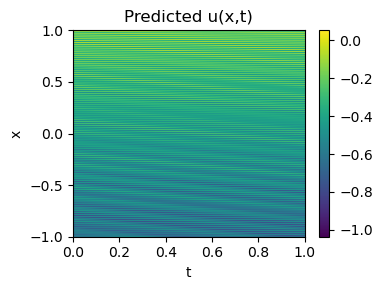

In [26]:
# Visualize PINNs 
res_test = torch.tensor(res_test, dtype=torch.float32, requires_grad=True).to(device)
x_test, t_test = res_test[:,0:1], res_test[:,1:2]

with torch.no_grad():
    pred = model(x_test, t_test)[:,0:1]
    pred = pred.cpu().detach().numpy()

pred = pred.reshape(512,201)

mat = scipy.io.loadmat('./AC.mat')
u = mat['uu'].reshape(512,201)


rl1 = np.sum(np.abs(u-pred)) / np.sum(np.abs(u))
rl2 = np.sqrt(np.sum((u-pred)**2) / np.sum(u**2))

print('relative L1 error: {:4f}'.format(rl1))
print('relative L2 error: {:4f}'.format(rl2))

plt.figure(figsize=(4,3))
plt.imshow(pred, extent=[0,1,-1,1], aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Predicted u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./convection_pinnsformer_pred.png')
plt.show()

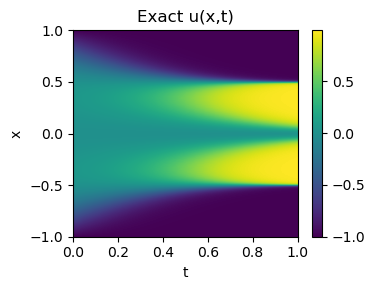

In [25]:
plt.figure(figsize=(4,3))
plt.imshow(u, extent=[0,1,-1,1], aspect='auto')
plt.xlabel('t')
plt.ylabel('x')
plt.title('Exact u(x,t)')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_exact.png')
plt.show()

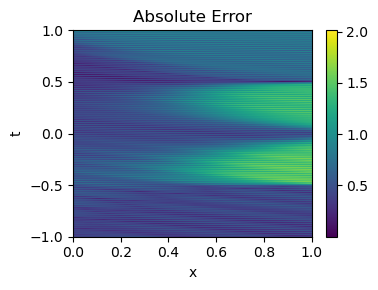

In [27]:
plt.figure(figsize=(4,3))
plt.imshow(np.abs(pred - u), extent=[0,1,-1,1], aspect='auto')
plt.xlabel('x')
plt.ylabel('t')
plt.title('Absolute Error')
plt.colorbar()
plt.tight_layout()
plt.savefig('./1dreaction_pinnsformer_error.png')
plt.show()

In [28]:
print(loss_track)
loss = [sum(sublist) for sublist in loss_track]
print(loss)
print(max(loss))

[[0.09587928652763367, 0.01918978989124298, 0.14424407482147217], [0.0848982036113739, 0.015164051204919815, 0.14272089302539825], [0.04959864169359207, 0.00024034756643231958, 0.1317613124847412], [0.08850719034671783, 0.0004608958261087537, 0.12311854213476181], [0.4707024097442627, 5.776577836513752e-06, 0.10852164030075073], [0.4713849127292633, 5.860010332980892e-06, 0.10843270272016525], [0.4857051968574524, 1.163254364655586e-05, 0.10781098157167435], [0.44397756457328796, 1.7402489902451634e-05, 0.1077827513217926], [0.42037954926490784, 2.414093069091905e-05, 0.10793051868677139], [0.41846826672554016, 2.4267113985843025e-05, 0.10794757306575775], [0.41582363843917847, 2.5151832232950255e-05, 0.10797002911567688], [0.4126168489456177, 2.7448721084510908e-05, 0.10799358040094376], [0.40709999203681946, 3.506123903207481e-05, 0.10802339017391205], [0.39965471625328064, 5.5466538469772786e-05, 0.10803501307964325], [0.3910902738571167, 0.00011093424109276384, 0.10796095430850983]

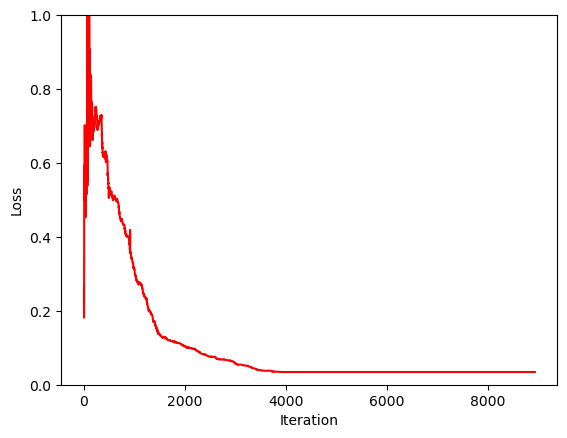

In [29]:
loss = [sum(sublist) for sublist in loss_track]
indices=list(range(len(loss)))
plt.figure()
plt.plot(indices,loss,color='red')
plt.xlabel('Iteration')
plt.ylabel('Loss')
# plt.yscale('log') #设置y轴为对数尺度，这样即使列表中有一些非常大的值，也不会影响其他值的可视化
# plt.xlim([0,100]) # 设置x轴的范围
plt.ylim([0,1]) # 设置y轴的范围
plt.show()